## **Log Overview**
---
|                        | Sepsis  | Permit | BPI 2012| BPI 2014 | Traffic |
|------------------------|--------:|-------:|--------:|---------:|--------:|
| #Traces                | 1050    | 7065   | 13087   | 41353    | 150370  |
| Trace Uncertainty      | 96%     | 13%    | 38%     | 93%      |  6%     |
| #Events                | 15214   | 86581  | 262200  | 369485   | 561470  |
| #Event Sets            | 10767   | 85456  | 248205  | 243186   | 549452  |
| Event Uncertainty      | 29%     |  1%    |  5%     | 40%      |  2%     |
| #unique events         | 16      | 51     | 24      |  9       | 11      |
| #uncertain Seq's       | 15      | 39     | 14      | 24       | 25      |
| max(len(unc.seq))      |  4      |  7     |  4      |  4       |  3      |
| avg(len(unc.seq))      |  3.0    |  2.7   |  2.4    |  2.6     |  2.0

### PIP installs and imports
---


In [ ]:
!pip install pm4py

     |████████████████████████████████| 696kB 2.6MB/s 
     |████████████████████████████████| 40.6MB 101kB/s 
  Created wheel for stringdist: filename=StringDist-1.0.9-cp36-cp36m-linux_x86_64.whl size=24378 sha256=32dbc03a7f1953f3b962d739e3233105f958a5a7a020277a3012dac720caacf8
  Stored in directory: /root/.cache/pip/wheels/c3/1b/bb/bf0de4d64d8ca38759811fe3353e441f12feb606fb3d1d2e11
  Created wheel for ciso8601: filename=ciso8601-2.1.3-cp36-cp36m-linux_x86_64.whl size=28303 sha256=32a21a421efa29ae5ef988b289ff458db16c44743e1abca4d8d6ef86cc5bc7e0
  Stored in directory: /root/.cache/pip/wheels/eb/32/e4/13bdaf7e245f82667b21e0cfb03d21224691a47fa9f9bc80a6
Successfully built stringdist ciso8601


In [ ]:
from pm4py.objects.log.importer.xes import factory as xes_import_factory
from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.algo.filtering.log.attributes import attributes_filter
from pm4py.algo.filtering.log.timestamp import timestamp_filter
import xml.etree.ElementTree as et
from pprint import pprint
from typing import Tuple 
import random
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib
matplotlib.rc('xtick', labelsize=8)
import numpy as np
from pathlib import Path
from itertools import product, permutations, combinations

from sklearn import model_selection
import tensorflow as tf
import keras

# **DSS Partial Order Resolution Probabilsitic Models**
---
---

In [ ]:
class FullTraceEquivalenceProbabilisticModel():
    
    def __init__(self, certain_log):
        self.certain_log = certain_log
        self.len_certain_log = len(certain_log)
        self.trace_frequency = dict()
        
        self.__get_trace_frequencies()

    def __get_trace_frequencies(self):
        for trace in self.certain_log:
            t = '|'
            for event in trace:
              t += event["concept:name"] + '|'
            self.trace_frequency[t] = self.trace_frequency.get(t, 0) + 1


    def P_trace(self, possible_resolution) -> float:
      pr = self.format_possible_resolution(possible_resolution)
      return self.trace_frequency.get(pr,0) / self.len_certain_log

    def format_possible_resolution(self, possible_resolution) -> str:
      pr = str()
      for event in possible_resolution:
        pr += event.rstrip('|')
      return pr + '|'


class NGramProbabilisticModel():

    def __init__(self, log):
        self.log = log
        self.log_set = self.__make_log_set()

        self.certain_sequences = [self.__make_certain_sequences(trace_set) for trace_set in log_set]

    def certain(self, activity_sequence: list, trace_set: dict) -> bool:
        certain_sequences = self.__make_certain_sequences(trace_set)
        for certain_sequence in certain_sequences:
            if __activities_in_sequence(activity_sequence, certain_sequence):
                return True
        return False

    def __make_log_set(self) -> list:
        log_set = []
        for trace in self.log:
            log_set.append(self.__make_trace_sets(trace))
        return log_set

    def __make_trace_sets(self, trace) -> dict:
        trace_set = dict()
        for event in trace:
            trace_set[str(event["time:timestamp"])] = trace_set.get(str(event["time:timestamp"]), []) + [event["concept:name"]]
        return trace_set

    def __make_certain_sequences(self, trace_set) -> list:
        '''
        For each uncertain trace we cut out the certain subtraces, e.g. [{1}, {2,3}, {4}, {5}] -> [[1],[4,5]]
        And in those we search for an activity sequence to be present
        Because for an activity sequence to be certain in a trace it must apper in a certain sequence of a trace
        '''
        certain_sequences = []
        certain_sequence = []
        for i, timestamp in enumerate(trace_set):
          if len(trace_set[timestamp]) == 1:
            if i == len(trace_set)-1:
              certain_sequence.append(trace_set[timestamp][0])
              certain_sequences.append(certain_sequence)
            else:
              certain_sequence.append(trace_set[timestamp][0])
          else:
            if certain_sequence:
              certain_sequences.append(certain_sequence)
            certain_sequence = []
        return certain_sequences 

    def __activities_in_sequence(self, activity_sequence: list, certain_sequence: list) -> bool:
        for i in range(len(certain_sequence) - len(activity_sequence) + 1):
            if certain_sequence[i:i+len(activity_sequence)] == activity_sequence:
                return True
        return False

    def P_a_activity_sequence(self, activity: str, activity_sequence: list) -> float:
        cnt1 = 0
        cnt2 = 0
        for trace_set in self.log_set:
            if certain(activity_sequence, trace_set):
                cnt2 += 1
            if certain(activity_sequence + [activity], trace_set):
                cnt1 += 1
        if cnt2 == 0: 
          return cnt1
        return cnt1/cnt2

    def P_n_gram(self, possible_resolution: list, n: int=2):
        #possible_resolution like [a, b, c]
        lower_bound = 1         #2 in the paper, but indexing here starts one before
        upper_bound = len(possible_resolution)
        result = 1.0
        for i in range(lower_bound,upper_bound):
            s_index = max(i-n+1, 0)         #the gram is not n long in the beginning, its 2 long, then 3, ... until it's always n long
            result *= self.__P_a_activitiy_sequence(possible_resolution[i], s_index)
        return result


class BinaryRelationsProbabilisticModel():

    def __init__(self, log):
        self.log = log
        self.log_set = self.__make_log_set()

    def order(self, a: str, b: str, trace_set) -> bool:
        trace_list = [event_set for timestamp, event_set in trace_set.items()]
        for i in range(len(trace_list)-1):
            if a in trace_list[i]:
                for j in range(i+1, len(trace_list)):
                    if b in trace_list[j]:
                        return True
        return False

    def contains_activities(self, a: str, b: str, trace_set) -> bool:
        activities = [event for timestamp, event_set in log_set[6].items() for event in event_set]
        return (a in activities and b in activities)

    def __make_log_set(self) -> list:
        log_set = []
        for trace in self.log:
            log_set.append(self.__make_trace_sets(trace))
        return log_set

    def __make_trace_sets(self, trace) -> dict:
        trace_set = dict()
        for event in trace:
            trace_set[str(event["time:timestamp"])] = trace_set.get(str(event["time:timestamp"]), []) + [event["concept:name"]]
        return trace_set

    def P_a_b(self, a:str, b:str) -> float:
        cnt1 = 0
        cnt2 = 0
        for trace_set in self.log_set:
            if contains_activities(a, b, trace_set):
                cnt2 += 1
                if order(a, b, trace_set):
                    cnt1 += 1
        if cnt2 == 0:
            return cnt1
        return cnt1 / cnt2

    def P_weak_order(self, possible_resolution: list) -> float:
        result = 1.0
        for i in range(len(possible_resolution)-1):
            for j in range(i+1, len(possible_resolution)):
                result *= self.P_a_b(possible_resolution[i], possible_resolution[j])
        return result

# **Functions for working with logs**
---
---

### functions for manipulating or extracting data from the log, cases or events
---

In [ ]:
#checks if a case is certain, gets called by split log
def case_is_certain(case_time_list):
    #doesnt take into account 
    for i in range(0, len(case_time_list)-1):
        if case_time_list[i] == case_time_list[i+1]:
            return False
    return True

#splits a log in two logs, the one holding only totally ordered traces and the one holding only partially ordered traces
def split_log(log):
    certain_log = list()
    uncertain_log = list()
    for case in log:
        times = list()
        for event in case:
            times.append(event["time:timestamp"])
        if case_is_certain(times):
            certain_log.append(case)
        else:
            uncertain_log.append(case)
    return certain_log, uncertain_log

#gets a list of the unique events as strings
def get_events(log):
    activities = attributes_filter.get_attribute_values(log, "concept:name")
    all_events = list(activities.keys())
    return all_events

#wraps the singular events to match the uncertain event sets; for readability purposes only
def beautify_events(all_singular_events):
  beautified_events = []
  for event in all_singular_events:
    event = '|' + event + '|'
    beautified_events.append(event)
  return beautified_events

#returns a list of the events the trace at log[index]
def get_trace(log, index):
    if index > len(log)-1:
        print("Error: index out of range.")
    else:
        trace = [event["concept:name"] for event in log[index]]
        return trace

#returns a list of lists, each containing the events from the traces of the given log
def get_traces(log):
    trace_list = list()
    for i in range(len(log)): 
        trace_list.append(get_trace(log, i))
            
    return trace_list

#returns a list of dicts  for each trace, the keys for a trace are the timestamps holding all events occuring at that time for a specific trace (sorted)
#only works for certain log
def make_log_set(log, sort=True) -> list:
  log_set = []
  for trace in log:
    log_set.append(make_trace_sets(trace, sort))
  return log_set

def make_trace_sets(trace, sort=True) -> dict:
  trace_set = dict()
  for event in trace:
    trace_set[str(event["time:timestamp"])] = trace_set.get(str(event["time:timestamp"]), []) + [event["concept:name"]]
  if sort:
    for key in trace_set:
      trace_set[key].sort()
  return trace_set

#gets the occuring uncertain sequences in the log as a set of tuples (=event sets) 
def get_uncertain_sequences(uncertain_log) -> set:
    uncertain_sequences = set()
    for i in range(0, len(uncertain_log)):
        j = 0
        while j < len(uncertain_log[i])-1:
            sequence = list()
            if uncertain_log[i][j]["time:timestamp"] == uncertain_log[i][j+1]["time:timestamp"]:
                time = uncertain_log[i][j]["time:timestamp"] 
                while j < len(uncertain_log[i]) and time == uncertain_log[i][j]["time:timestamp"]:
                    sequence.append(uncertain_log[i][j]["concept:name"])
                    j += 1
            else:
                j += 1    
            if sequence:
                uncertain_sequences.add(tuple(sorted(sequence)))
    return uncertain_sequences

#turns the uncertain sequence (set of tuple) into a list of concatenated strings of the uncertain sequences
#so they can be used as features / categories for encoding
def make_list_uncertain_sequences(uncertain_sequences):
    list_uncertain_events = list()
    for tup in uncertain_sequences:
        event = str()
        for element in tup:
            event = event + '|' + element
        event += '|'
        list_uncertain_events.append(event)
    return list_uncertain_events

#turns a log, where concurrent events are in sets, into a list (=log) of lists(=traces), were concurrent events are concatenated
#so the log / traces can be encoded
def concat_trace_sets(set_log) -> list:
    input_list = list()
    for trace in set_log:
        trace_list = list()
        for key in trace:
            event = str()
            for e in trace[key]:
                event = event + '|' + e
            event += '|'
            trace_list.append(event)
        input_list.append(trace_list)
    return input_list

#builds all sequences of length 1 to k from the activity universe using itertools product
def product_up_to_k(singular_events: list, k: int) -> list:
  products = []
  for i in range(1,k+1):
    products += itertools_tuples_to_list(list(product(singular_events, repeat=i)), i)
  
  return products

#extract those from the possible resolutions that are double, e.g. for {a,b,a} there would be 2x 'aab', which is only needed once, right?
def make_possible_resolutions(uncertain_events_tuples):
  possible_resolutions = list()
  for tup in uncertain_events_tuples:
    for p in permutations(tup):
      word = '|'.join(p)
      word = '|' + word + '|'          
      if word not in possible_resolutions:
        possible_resolutions.append(word)
  return possible_resolutions

### printing functions
---

In [ ]:
#prints the trace at index = num
def print_trace(log, num):
  if num > len(log) - 1:
    print("Error: index out of range.")
  else:
    case = log[num]
    print("\n case id: %s" % (log[num].attributes["concept:name"]))
    for event_index, event in enumerate(log[num]):
        a = "event index: " + str(event_index)
        b = "event activity: " + str(event["concept:name"])
        c = "time: " + str(event["time:timestamp"])
        print('{:20s}{:60s}{:20s}'.format(a,b,c))

#prints all cases up to the given number
def print_traces(log, num_traces):
    if(num_traces > len(log)):
        print("You want to print more traces then there are in the log!")
    else:
        for i in range(num_traces):
            print_trace(log, i)

# compute the fraction from where the order in the log differs from the alphabetically sorted order (for uncertain events only)
def print_event_information(concat_log: list, concat_log_unsorted: list):
  events = 0
  unc_events = 0
  cnt = 0
  for i in range(len(concat_log)):
    for j in range(len(concat_log[i])):
      events += 1
      if concat_log[i][j] in uncertain_events:
        unc_events +=1
        if concat_log[i][j] != concat_log_unsorted[i][j]:
          cnt += 1
  print("Number of events", events)
  print("Uncertainty of events:", unc_events/events)
  print("Number of uncertain events:", unc_events, "Count of uncertain events that are not in alphabetical order in the log", cnt)
  print("Fraction of uncertain events that are (not) in alphabetical order in the log:", 1-cnt/unc_events, "(",cnt/unc_events, ")")

### numerical functions
---
for getting statistical (avg, mean, ...) and numerical data (number of events, frequency of events)

In [ ]:
def avg_trace_length(log):
    avg = 0
    for trace in log:
        avg += len(trace)
    return round(avg / len(log),2)

def min_trace_length(log):
    min = 10000
    for trace in log:
        if len(trace) < min:
            min = len(trace)
    return min

def max_trace_length(log):
    max = 0
    for trace in log:
        if len(trace) >= max:
            max = len(trace)
    return max

#returns the amount of events in the log 
def num_events(log):
    num_events = 0 
    for trace in log:
        #num_events += len(trace)
        for event in trace:
          num_events += 1
    return num_events

# returns for each single event its frequency in the log
def freq_of_events(log):
    unique_events = get_events(log)
    frequency_of_events = dict()
    for event in unique_events:
        frequency_of_events[event] = 0
    for trace in log:
        for event in trace:
            frequency_of_events[event["concept:name"]] += 1

    return frequency_of_events

#gets for the occuring uncertain sequences the amount of times they come up in the (uncertain) log, as a dict data structure
def freq_uncertain_sequences(set_log, uncertain_sequences):
    num_uncertain_sequences = dict()
    for trace in set_log:
        for key in trace:
            if len(trace[key]) > 1:
                if tuple(trace[key]) not in num_uncertain_sequences:
                    num_uncertain_sequences[tuple(trace[key])] = 1
                else:
                    num_uncertain_sequences[tuple(trace[key])] += 1

    return num_uncertain_sequences

### visualization functions
---
fdata knowledge, drawing histograms, ...

In [ ]:
#lots of names inside not defined, e.g. log_avg or log_min, ...
def visualize_log(log):
    NUM_TRACES = len(log)
    color_log, color_certain, color_uncertain = 'tab:blue', 'darkseagreen', 'sandybrown'
    #visualize basic log information

    fig, ax = plt.subplots(1,2)
    #certain and uncertain log length as pie chart
    def func(pct, allvals):
        absolute = int(pct/100.*np.sum(allvals))
        return "{:.1f}%\n({:d} Traces)".format(pct, absolute)

    labels = ['Certain Part', 'Uncertain Part']
    sizes = [len(certain_log)/NUM_TRACES*100, len(uncertain_log)/NUM_TRACES*100]
    wedges, texts, autotexts = ax[0].pie(sizes, startangle=90, colors = [color_certain, color_uncertain], 

                                            autopct=lambda pct: func(pct, [len(certain_log), len(uncertain_log)]), textprops=dict(color="k"))
    ax[0].set_title('Traces of the Log that are Certain, Uncertain Respectively')

    #measures for trace length
    X1 = ['avg', 'min', 'max', 'c_avg', 'c_min', 'c_max', 'u_avg', 'u_min', 'u_max'] 
    y1 = [log_avg, log_min, log_max, certain_avg, certain_min, certain_max, uncertain_avg, uncertain_min, uncertain_max]
    r2 = ax[1].bar(X1, y1, color=[color_log, color_log, color_log, color_certain, color_certain, color_certain, color_uncertain, color_uncertain, color_uncertain])
    ax[1].set_title('Trace Length Measures in the whole, certain and uncertain Log')
    ax[1].set_ylabel('Number of Events')

    #frequency of each even in the log
    fig1, ax1 = plt.subplots(3,1)
    ax1[0].bar(range(len(frequency_of_events_log)), frequency_of_events_log.values(), align='center')
    ax1[0].set_title('Log')
    ax1[0].set_ylabel('Amount of Occurance')
    ax1[1].bar(range(len(frequency_of_events_certain)), frequency_of_events_certain.values(), align='center')
    ax1[1].set_title('Certain Log')
    ax1[1].set_ylabel('Amount of Occurance')
    ax1[2].bar(range(len(frequency_of_events_uncertain)), frequency_of_events_uncertain.values(), align='center')
    ax1[2].set_title('Uncertain Log')
    ax1[2].set_ylabel('Amount of Occurance')
    fig1.suptitle('Frequency of Events in the whole, certain and uncertain log', fontsize=20)
    plt.setp(ax1, xticks=[i for i in range(len(all_events))], xticklabels = list(frequency_of_events_log.keys()))

    # visualize uncertain trace frequency
    X = list()
    y = list()
    for key in num_uncertain_sequences:
        s = ''
        for event in key:
            s += event[:2]
        X.append(s)
        y.append(num_uncertain_sequences[key])

    fig2, ax2 = plt.subplots()    
    ax2.bar(X,y)
    ax2.set_title('Uncertain Set Frequency')
    ax2.set_xlabel('Uncertain Trace Set')
    ax2.set_ylabel('Frequency in the Log')


    plt.show()

# **Abstracting timestamps functions**
---
---

In [ ]:
import datetime

#we could also elongate the uncertain sequence, by making 1 more timestamps before/after the unc.seq. 
# the same as the timestamp in the uncertain sequence


def abstract_microsecond(timestamp: datetime.datetime):
  return timestamp.replace(microsecond=0)

def abstract_second(timestamp: datetime.datetime):
  return timestamp.replace(second=0, microsecond=0)

def abstract_minute(timestamp: datetime.datetime):
  return timestamp.replace(minute=0, second=0, microsecond=0)

def abstract_hour(timestamp: datetime.datetime):
  return timestamp.replace(hour=0, minute=0, second=0, microsecond=0)

def abstract_day(timestamp: datetime.datetime):
  return timestamp.replace(day=1, hour=0, minute=0, second=0, microsecond=0)

def abstract_month(timestamp: datetime.datetime):
  return timestamp.replace(month=1, day=1, hour=0, minute=0, second=0, microsecond=0)

def abstract_year(timestamp: datetime.datetime):
  return timestamp.replace(year=1993, month=1, day=1, hour=0, minute=0, second=0, microsecond=0)

def copy_timestamp(timestamp: datetime.datetime):
  return timestamp.replace()


#add functions for abstracting times per event, trace or log 

# **Encoder Classes** 
---
---
we consider two different approaches of encoding

### **1.1 Encoder Class**
---

encodes lists of traces in either 
 *   one-hot-encoding 
 *   embed-encoding 

In [ ]:
class BasicEncoder():

    def __init__(self, activity_list, num_oov_buckets, embedding_dim=None):
        self.activities = activity_list
        self.num_oov_buckets = num_oov_buckets

        self.all_subsets_or_subsequences #the second encoder will rather get the normal single events/all possibble resolutions and compute the table in here while also

        self.indices = tf.range(len(self.activities), dtype=tf.int64)
        self.table_init = tf.lookup.KeyValueTensorInitializer(self.activities, self.indices)
        self.table = tf.lookup.StaticVocabularyTable(self.table_init, self.num_oov_buckets)

        #only needed for embeddings
        if embedding_dim:
            embed_init = tf.random.uniform([len(self.activities)+self.num_oov_buckets, embedding_dim])
            self.embedding_matrix = tf.Variable(embed_init)

    def lookup_indices(self, trace):
        categories = tf.constant(trace)
        cat_indices = self.table.lookup(categories)
        return cat_indices

    def one_hot_encode_trace(self, trace): #trace is a list of strings, where each string = one of the possible event as in self.activities
        cat_indices = self.lookup_indices(trace)
        cat_one_hot = tf.one_hot(cat_indices, depth=len(self.activities) + self.num_oov_buckets)
        return cat_one_hot

    def one_hot_encode_log(self, log):
        #log is not in the format as when loaded with pm4py, but rather a list(=log) of lists(=traces) containing the activities as strings
        encoded_inputs = []
        for trace in log:
            encoded_inputs.append(self.one_hot_encode_trace(trace))
        
        return encoded_inputs

    def embed_encode_trace(self, trace): #trace is a list of strings, where each string = one of the possible event as in self.activities
        cat_indices = self.lookup_indices(trace)
        cat_embed = tf.nn.embedding_lookup(self.embedding_matrix, cat_indices)
        return cat_embed

    def embed_encode_log(self, log):
      #log is not in the format as when loaded with pm4py, but rather a list(=log) of lists(=traces) containing the activities as strings
        encoded_inputs = []
        for trace in log:
            encoded_inputs.append(self.embed_encode_trace(trace))
        
        return encoded_inputs

    def print_indice(self, activity: str):
      tf.print(self.table.lookup(tf.constant(activity)))

### **1.2 Encoder Class**
---

1.2 encodes a lists of traces, such that for an event set, say {v,w,x}
 * in the encoding all subsequences of that event set are _marked_ with a 1, so in this case we would mark 
  * v, w, x 
  * vw, vx, wv, wx, xv, xw 
  * vwx, vxw, wvx, wxv, xvw, xwv 

* then we sum up all possiblities that make a logical outcome ? 
* is v + wx different then v + w + x or vwx ?  

In [ ]:
class SubEncoder():
  #in init make the list of subsets/sequences in class and also btw the look up table for encoding 
  def __init__(self, activity_list, num_oov_buckets, mode: str):
    self.activities = activity_list
    self.num_oov_buckets = num_oov_buckets
    self.mode = mode

    self.indices = tf.range(len(self.activities), dtype=tf.int64)
    self.table_init = tf.lookup.KeyValueTensorInitializer(self.activities, self.indices)
    self.table = tf.lookup.StaticVocabularyTable(self.table_init, self.num_oov_buckets)

    self.subset_table = {}
    self.subsequence_table = {}

  def lookup_indices(self, event_set):
    categories = tf.constant(event_set)         #converting this into tensor data structure
    cat_indices = self.table.lookup(categories)  #get the indices in lookup table for the subsets buildable from the input event set
    return cat_indices

  def sub_encode_event_set(self, event_set):
    if self.mode == 'i':
      all_subs = self.make_subsets(event_set) 
    elif self.mode == 'o':
      all_subs = self.make_subsequences(event_set)
    else:
      print('Wrong mode entered:', self.mode, 'Choose between i or o.')

    cat_indices = self.lookup_indices(all_subs)                                                             #make all subseqs of event set, e.g. {a,b} -> [a, b, ab, ba] #OPEN how to handle double elements like {a,b,a}                                              
    subs_list =  [t for t in tf.one_hot(cat_indices, depth=len(self.activities) + self.num_oov_buckets)]    #one hot encode each indices and make it a list of tensors e.g [<100>,<001>]
    return tf.math.add_n(subs_list)                                                                         #to finally sum up the tensor for getting one tensor with all the 1's, e.g <101>

  def sub_encode_trace(self, trace):
    encoded_trace = []
    for event_set in trace:
      encoded_trace.append(self.sub_encode_event_set(event_set))
    return encoded_trace

  def sub_encode_log(self, log):  
    encoded_log = []
    for trace in log:
      encoded_log.append(self.sub_encode_trace(trace))
    return encoded_log

  #HELPER FUNCTIONS
 
  #brakes down an event set in all possible singular events
  #gets a list of events (used to be part of a uncertain event set) and builds all possible combinations for encoding in encoder class
  def make_subsets (self, event_set: str, separizer: str='|'):
    single_events = ['|' + single_event + '|' for single_event in event_set[1:-1].split(separizer)]
    all_subsets= []
    for i in range(1,len(single_events)+1):
      all_subsets += itertools_tuples_to_list( list(combinations(single_events, i)), i)

    return all_subsets
  
  #for a given subsequence omit all subsequence keeping the order!
  def make_subsequences (self, event_set:str, separizer: str='|'):
    all_subsequences = [event_set] + ['|' + single_event + '|' for single_event in event_set[1:-1].split(separizer)] #add subseqeuences of length 1 and the starting sequence
    length = len([x for x in event_set.split('|')])-2

    for i in range(2,length):                                   #get all subsets of length >=2 for the current possible resolution 
        left, right = '|'+event_set.split('|',i)[i], event_set.rsplit('|',i)[0]+'|'
        if left not in all_subsequences:
            all_subsequences.append(left)
        if right not in all_subsequences:
            all_subsequences.append(right)

    return all_subsequences

# **Helper Functions**
---
---

In [ ]:
#using itertools product or permutations returns a list of tuples
#this converts it the string representation of events, we work with here
def itertools_tuples_to_list(tupleList: list, k: int) -> list:
  result = []
  for tup in tupleList:
    possible_resolution = '|'
    for i in range(0,k):
      possible_resolution += tup[i].lstrip('|')
    if possible_resolution not in result:          # or len(tup)==1:
      result.append(possible_resolution)
  return result

# **Data Preprocessing**
---
---

In [ ]:
# function for splitting data randomly into test and train data
def split_train_test(input_data, target_data, train_ratio=0.8) -> Tuple[list, list, list, list]:
  if type(input_data) == type(list()):
    train_size = int(len(input_data) * train_ratio)
    indices = [i for i in range(len(input_data))]
    random.shuffle(indices)
    train_indices = indices[:train_size]
    test_indices = indices[train_size:]

    X_train_full, X_test, y_train_full, y_test = [], [], [], []
    for index in train_indices:
      X_train_full.append(input_data[index])
      y_train_full.append(target_data[index])

    for index in test_indices:
      X_test.append(input_data[index])
      y_test.append(target_data[index])

    return X_train_full, X_test, y_train_full, y_test
  else:
    print("Type", type(input_data), "not supported yet.")
    

# **Testing Area**
---
---




### loading the logs 
---

In [ ]:
sepsis_log = xes_importer.apply("/content/drive/My Drive/Colab Notebooks/logs/Sepsis_Cases_Event_Log.xes")
permit_log = xes_importer.apply("/content/drive/My Drive/Colab Notebooks/logs/PermitLog.xes")
b12_log = xes_importer.apply("/content/drive/My Drive/Colab Notebooks/logs/BPI_Challenge_2012.xes")
b14_log = xes_importer.apply("/content/drive/My Drive/Colab Notebooks/logs/BPI_Challenge_2014.xes")
traffic_log = xes_importer.apply("/content/drive/My Drive/Colab Notebooks/logs/traffic_fines.xes")

### preparing and manipulating log data
---

In [ ]:
log = sepsis_log
certain_log, uncertain_log = split_log(log)

singular_events = get_events(log)                                                             #all single events as a list
singular_events = beautify_events(singular_events)
# getting the possible events ready, i.e. the elements of the lookup table for encoding
uncertain_events_tuples = get_uncertain_sequences(uncertain_log)                                         #all occuring uncertain sequences as tuples
uncertain_events = make_list_uncertain_sequences(uncertain_events_tuples)                                      #all occuring sequences in a list, concatenated

all_events = singular_events + uncertain_events
all_possible_resolutionss = singular_events + make_possible_resolutions(uncertain_events_tuples)  

# get all singular events and their amount, and k
SIZE_ACTIVITY_UNIVERSE = len(singular_events)
K = len(max(uncertain_events_tuples, key=len))

#print("Length of: Log:", len(log), "Certain Log:", len(certain_log), "Uncertain Log:", len(uncertain_log))
#print("Number of singular events:", SIZE_ACTIVITY_UNIVERSE, "Number of possible input events:", len(all_events))

In [ ]:
#getting the traces in a form such that the event sequences match the lookup table for encoding, i.e. trace = list of (concatenated) event-strings

#data structure: a log is a list of dicts(=traces), where the key is the timestamp and it contains all single events happening at that time
log_set, certain_log_set, uncertain_log_set = make_log_set(log), make_log_set(certain_log), make_log_set(uncertain_log)

#data structure: a log is a list of lists(=traces), where each event is represented as a string, those who had the same timestamps in a trace are concatenated
concat_log, concat_certain_log, concat_uncertain_log = concat_trace_sets(log_set), concat_trace_sets(certain_log_set), concat_trace_sets(uncertain_log_set)

In [ ]:
#creating all possible event sets, for output encoding, up to the length of the longest, observed uncertain sequence 
#here the ordering does matter, i.e. it contains the resolutions abc, acb, bac, bca, cab, cba for an input event set {a,b,c}
really_all_possible_resolutions = product_up_to_k(singular_events, 4)
print(len(really_all_possible_resolutions))

69904


In [ ]:
print(log_set[0])

{'2014-10-22 11:15:41+02:00': ['ER Registration'], '2014-10-22 11:27:00+02:00': ['CRP', 'LacticAcid', 'Leucocytes'], '2014-10-22 11:33:37+02:00': ['ER Triage'], '2014-10-22 11:34:00+02:00': ['ER Sepsis Triage'], '2014-10-22 14:03:47+02:00': ['IV Antibiotics', 'IV Liquid'], '2014-10-22 14:13:19+02:00': ['Admission NC'], '2014-10-24 09:00:00+02:00': ['CRP', 'Leucocytes'], '2014-10-26 08:00:00+01:00': ['CRP', 'Leucocytes'], '2014-10-28 08:00:00+01:00': ['CRP', 'Leucocytes'], '2014-10-30 08:00:00+01:00': ['CRP', 'Leucocytes'], '2014-10-31 08:00:00+01:00': ['CRP', 'Leucocytes'], '2014-11-02 08:00:00+01:00': ['CRP', 'Leucocytes'], '2014-11-02 15:15:00+01:00': ['Release A']}


In [ ]:
res = []
i=5
for t in log_set[i]:
  res += log_set[i][t]
  print(log_set[i][t])

print(res)

['ER Registration']
['ER Triage']
['ER Sepsis Triage']
['CRP', 'LacticAcid', 'Leucocytes']
['IV Antibiotics', 'IV Liquid']
['Admission NC']
['Release A']
['ER Registration', 'ER Triage', 'ER Sepsis Triage', 'CRP', 'LacticAcid', 'Leucocytes', 'IV Antibiotics', 'IV Liquid', 'Admission NC', 'Release A']


In [ ]:
a = FullTraceEquivalenceProbabilisticModel(certain_log)
b = NGramProbabilisticModel(log)
c = BinaryRelationsProbabilisticModel(log)

In [ ]:
concat_certain_log[0]

['|ER Registration|', '|ER Triage|', '|ER Sepsis Triage|']

In [ ]:
a.trace_frequency

{'|ER Registration|ER Triage|ER Sepsis Triage|': 35,
 '|ER Registration|ER Triage|ER Sepsis Triage|Admission NC|Release A|': 2,
 '|ER Registration|ER Triage|ER Sepsis Triage|CRP|Admission NC|Admission NC|Release A|Return ER|': 1,
 '|ER Registration|ER Triage|ER Sepsis Triage|Leucocytes|': 1,
 '|ER Registration|ER Triage|ER Sepsis Triage|Leucocytes|Admission NC|Leucocytes|Release A|': 1,
 '|ER Registration|ER Triage|ER Sepsis Triage|Leucocytes|Admission NC|Release A|': 2,
 '|ER Registration|ER Triage|ER Sepsis Triage|Leucocytes|Admission NC|Release A|Return ER|': 1,
 '|ER Registration|ER Triage|ER Sepsis Triage|Leucocytes|Leucocytes|': 1}

### basic encoding

---

In [ ]:
# encoding the input log
i_encoder = BasicEncoder(all_events, 1)
encoded_inputs = i_encoder.one_hot_encode_log(concat_log)

# for assuming the correct order is as in the log 
# make new encoder, since our output has more possibilities
set_log_unsorted = make_set_log(log, False)
concat_log_unsorted = concat_trace_sets(set_log_unsorted)


o_encoder = BasicEncoder(all_possible_resolutionss, 1)      
encoded_targets = o_encoder.one_hot_encode_log(concat_log_unsorted) 


### advanced encoding

---

In [ ]:
# for all occuring event set as inputs for encoding we consider also all subsets of these sets and mark them 
# i.e. getting the subsets for all occuring uncertain event sets

def all_subsets(event_set) -> list:
    length = len([x for x in event_set.split('|')])-2
    if length == 1:
        return [event_set]
    else:
        singles = ['|' + e + '|' for e in event_set[1:-1].split('|')]
        subsets = []
        for i in range(1,len(singles)+1):
            combis = itertools_tuples_to_list(list(combinations(singles, i)), i)
            for combi in combis:
                if combi not in subsets:
                    subsets.append(combi)
    subsets.sort(key=len)
    return subsets

all_events_subsets = []
for event_set in all_events:
  all_events_subsets += [subset for subset in all_subsets(event_set) if subset not in compare]

#TODO make subsets dict

In [ ]:
#second encoding
i_sub_encoder = SubEncoder(all_events_combinations, 1, 'i')
sub_encoded_inputs = i_sub_encoder.sub_encode_log(concat_log)

In [ ]:
# for all possible resoultions of the occuring event sets for outputs we consider all subsequences of these possible resolutions and mark them
# i.e. getting the subsequences for all possible resolutions of all occuring uncertain event sets

def all_subsequences(resolution: str) -> list:
    length = len([x for x in resolution.split('|')])-2
    if length == 1:
        return [resolution]
    else:
        subsequences = [resolution] + ['|' + e + '|' for e in resolution[1:-1].split('|')]
        for i in range(2,length):
            subsequences.append('|'+resolution.split('|',i)[i])
            subsequences.append(resolution.rsplit('|',i)[0]+'|') 
        return subsequences

all_resolutions_subsequences = []
for possible_resolution in all_possible_resolutionss:
  all_resolutions_subsequences += [subsequence for subsequence in all_subsequences(possible_resolution) if subsequence not in compare]
#TODO: make subsequences dict

136


In [ ]:
o_sub_encoder = SubEncoder(all_possible_resolutionss_combis, 1, 'o')
sub_encoded_targets = o_sub_encoder.sub_encode_log(concat_log)

### feedforward ANN
---

In [ ]:
encoded_ievents = list()
for trace in encoded_inputs:
  for event in trace:
    encoded_ievents.append(event)

encoded_tevents = list()
for trace in encoded_targets:
  for event in trace:
    encoded_tevents.append(event)

In [ ]:
X_train_full, X_test, y_train_full, y_test = split_train_test(encoded_ievents, encoded_tevents)

In [ ]:
split_index2 = int(len(X_train_full)/100*10)          #make valid data 10% and train data the rest
X_valid, X_train = X_train_full[:900], X_train_full[900:]
y_valid, y_train = y_train_full[:900], y_train_full[900:]

In [ ]:
type(X_train[0])

tensorflow.python.framework.ops.EagerTensor

In [ ]:
tX_valid, tX_train = tf.convert_to_tensor(X_valid), tf.convert_to_tensor(X_train)
ty_valid, ty_train = tf.convert_to_tensor(y_valid), tf.convert_to_tensor(y_train)
print(tX_train.shape)
print(ty_train.shape)

(193648, 34)
(193648, 135)


In [ ]:
type(tX_train[0])

tensorflow.python.framework.ops.EagerTensor

In [ ]:
#setting up feedforward-ANN
model = tf.keras.models.Sequential([
    keras.layers.Input(shape=(91,)),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(200, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(115, activation="softmax"),
])



In [ ]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 300)               27600     
_________________________________________________________________
dense_11 (Dense)             (None, 300)               90300     
_________________________________________________________________
dense_12 (Dense)             (None, 200)               60200     
_________________________________________________________________
dense_13 (Dense)             (None, 100)               20100     
_________________________________________________________________
dense_14 (Dense)             (None, 115)               11615     
Total params: 209,815
Trainable params: 209,815
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(tX_train, ty_train, epochs=20,
                    validation_data=(tX_valid, ty_valid))

Epoch 1/20
2109/2109 [==============================] - 6s 3ms/step - loss: 0.0843 - accuracy: 0.9892 - val_loss: 0.0125 - val_accuracy: 0.9978
Epoch 2/20
2109/2109 [==============================] - 6s 3ms/step - loss: 0.0034 - accuracy: 0.9993 - val_loss: 0.0140 - val_accuracy: 0.9978
Epoch 3/20
2109/2109 [==============================] - 6s 3ms/step - loss: 0.0033 - accuracy: 0.9993 - val_loss: 0.0109 - val_accuracy: 0.9989
Epoch 4/20
2109/2109 [==============================] - 6s 3ms/step - loss: 0.0031 - accuracy: 0.9993 - val_loss: 0.0108 - val_accuracy: 0.9978
Epoch 5/20
2109/2109 [==============================] - 6s 3ms/step - loss: 0.0013 - accuracy: 0.9997 - val_loss: 0.0226 - val_accuracy: 0.9956
Epoch 6/20
2109/2109 [==============================] - 6s 3ms/step - loss: 0.0019 - accuracy: 0.9995 - val_loss: 0.0097 - val_accuracy: 0.9989
Epoch 7/20
2109/2109 [==============================] - 6s 3ms/step - loss: 0.0025 - accuracy: 0.9994 - val_loss: 0.0117 - val_accuracy:

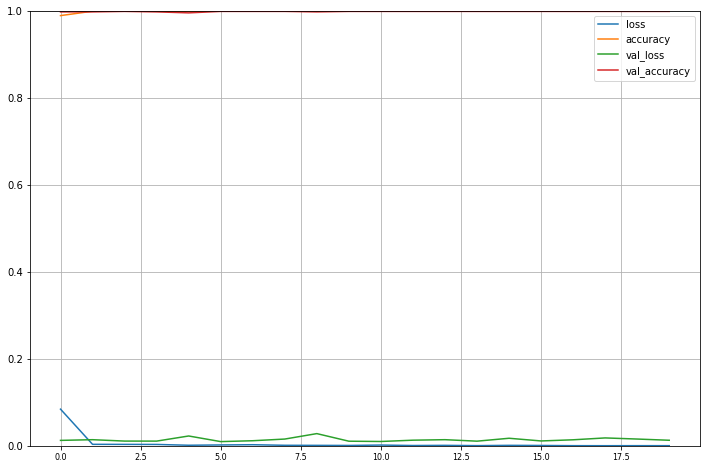

In [ ]:
pd.DataFrame(history.history).plot(figsize=(12,8))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()